## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [3]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

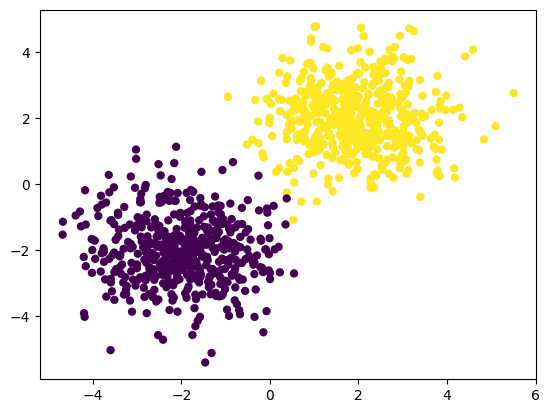

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [5]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [112]:
# batch generator
def get_batches(dataset, batch_size):
    X_i, Y_i = dataset
    n_samples = X_i.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X_i[batch_idx], Y_i[batch_idx]

### Train

Basic training loop. Examine it.

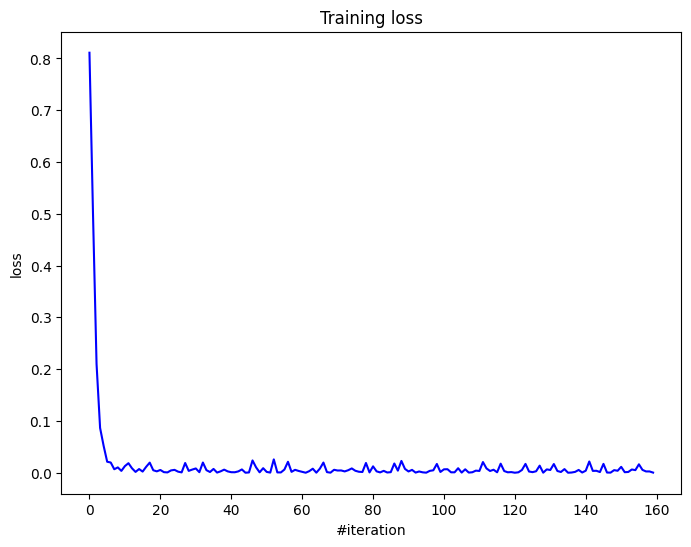

Current loss: 0.000297


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [9]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

--2024-12-17 00:39:28--  https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2697 (2.6K) [text/plain]
Saving to: ‘mnist.py’

mnist.py            100%[===================>]   2.63K  --.-KB/s    in 0s      

2024-12-17 00:39:28 (35.0 MB/s) - ‘mnist.py’ saved [2697/2697]



In [54]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [56]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [68]:
len(X_train)

56000

In [57]:
y_train = np.expand_dims(y_train.to_numpy(), 1)

In [58]:
y_test = np.expand_dims(y_test.to_numpy(), 1)

One-hot encode the labels first.

In [59]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)


In [60]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

In [129]:
net_i = Sequential()
net_i.add(Linear(784, 256))
net_i.add(ReLU())
net_i.add(Linear(256, 10))
net_i.add(LogSoftMax())

In [96]:
len(loss_history)

0

In [97]:
len(X_train)/56

1000.0

In [103]:
print(loss_history)

[]


In [130]:
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state = {}
criterion = ClassNLLCriterion()
relu_loss_history = []
batch_size = 56

for i in range(6):
    for x_batch, y_batch in get_batches((X_train.to_numpy(), y_train), batch_size):

        net_i.zeroGradParameters()

        # Forward
        predictions = net_i.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net_i.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net_i.getParameters(),
                     net_i.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        relu_loss_history.append(loss)

In [168]:
net_i = Sequential()
net_i.add(Linear(784, 256))
net_i.add(BatchNormalization())
net_i.add(ChannelwiseScaling(256))
net_i.add(ReLU())
net_i.add(Linear(256, 10))
net_i.add(LogSoftMax())

In [169]:
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state = {}
criterion = ClassNLLCriterion()
batch_loss_history = []
batch_size = 56

for i in range(6):
    for x_batch, y_batch in get_batches((X_train.to_numpy(), y_train), batch_size):

        net_i.zeroGradParameters()

        # Forward
        predictions = net_i.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net_i.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net_i.getParameters(),
                     net_i.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        batch_loss_history.append(loss)

In [137]:
net_ix = Sequential()
net_ix.add(Linear(784, 256))
net_ix.add(BatchNormalization())
net_ix.add(ChannelwiseScaling(256))
net_ix.add(LeakyReLU())
net_ix.add(Linear(256, 10))
net_ix.add(LogSoftMax())

In [138]:
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state = {}
criterion = ClassNLLCriterion()
lrelu_loss_history = []
batch_size = 56

for i in range(6):
    for x_batch, y_batch in get_batches((X_train.to_numpy(), y_train), batch_size):

        net_ix.zeroGradParameters()

        # Forward
        predictions = net_ix.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net_ix.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net_ix.getParameters(),
                     net_ix.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        lrelu_loss_history.append(loss)

In [141]:
net_iy = Sequential()
net_iy.add(Linear(784, 256))
net_iy.add(BatchNormalization())
net_iy.add(ChannelwiseScaling(256))
net_iy.add(SoftPlus())
net_iy.add(Linear(256, 10))
net_iy.add(LogSoftMax())

In [142]:
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state = {}
criterion = ClassNLLCriterion()
sp_loss_history = []
batch_size = 56

for i in range(6):
    for x_batch, y_batch in get_batches((X_train.to_numpy(), y_train), batch_size):

        net_iy.zeroGradParameters()

        # Forward
        predictions = net_iy.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net_iy.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net_iy.getParameters(),
                     net_iy.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        sp_loss_history.append(loss)

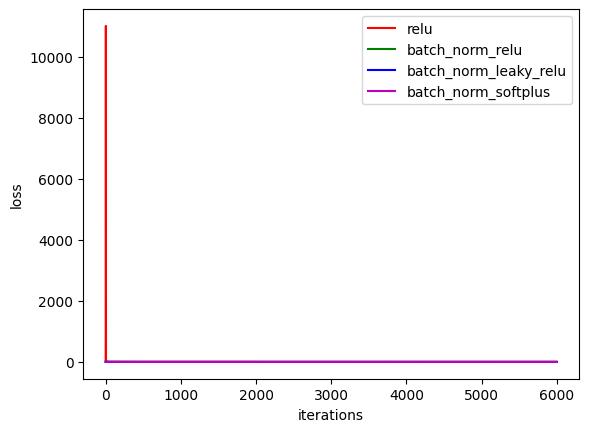

In [152]:
plt.plot(relu_loss_history, color='r', label='relu')
plt.plot(batch_loss_history, color='g', label='batch_norm_relu')
plt.plot(lrelu_loss_history, color='b', label='batch_norm_leaky_relu')
plt.plot(sp_loss_history, color='m', label='batch_norm_softplus')

plt.yscale='logit'
plt.xlabel("iterations")
plt.ylabel("loss")


plt.legend()


plt.show()

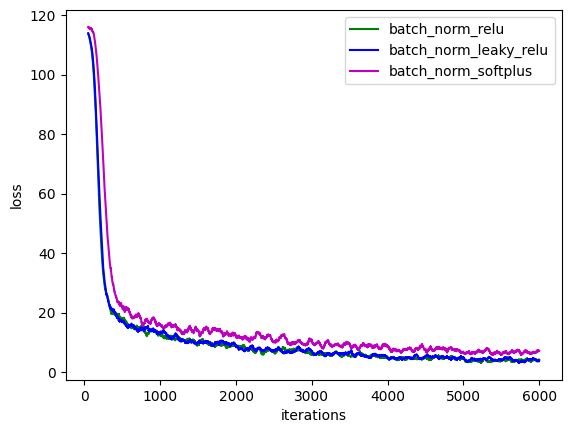

In [182]:
import pandas as pd
plt.plot(pd.DataFrame(batch_loss_history).rolling(50).sum()[50:], color='g', label='batch_norm_relu')
plt.plot(pd.DataFrame(lrelu_loss_history).rolling(50).sum()[50:], color='b', label='batch_norm_leaky_relu')
plt.plot(pd.DataFrame(sp_loss_history).rolling(50).sum()[50:], color='m', label='batch_norm_softplus')

plt.yscale='symlog'
plt.xlabel("iterations")
plt.ylabel("loss")


plt.legend()


plt.show()

In [161]:
net_i = Sequential()
net_i.add(Linear(784, 256))
net_i.add(BatchNormalization())
net_i.add(ChannelwiseScaling(256))
net_i.add(ReLU())
net_i.add(Linear(256, 10))
net_i.add(LogSoftMax())

In [162]:
optimizer_config = {'learning_rate':0.01, 'beta1':0.5, 'beta2':0.5, 'epsilon':0.01}
optimizer_state = {}
criterion = ClassNLLCriterion()
batch_adam_loss_history = []
batch_size = 56

for i in range(6):
    for x_batch, y_batch in get_batches((X_train.to_numpy(), y_train), batch_size):

        net_i.zeroGradParameters()

        # Forward
        predictions = net_i.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net_i.backward(x_batch, dp)

        # Update weights
        adam_optimizer(net_i.getParameters(),
                     net_i.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        batch_adam_loss_history.append(loss)

In [167]:
batch_adam_loss_history[-20:]

[0.10306671051466708,
 0.03088884874628167,
 0.0140106395713597,
 0.029360138935422497,
 0.026794245744596084,
 0.014792460748220205,
 0.023938388564449874,
 0.005981294401550531,
 0.10860104904989554,
 0.005669019549240401,
 0.013062157822652461,
 0.06465736034302265,
 0.07290399556704949,
 0.004790278690639261,
 0.06596294780798959,
 0.007173100888367099,
 0.06561636118038813,
 0.02143575878839716,
 0.003326125342964206,
 0.010784271093972102]

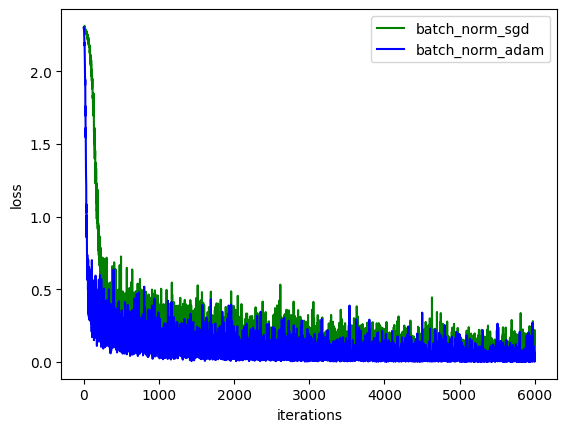

In [172]:
plt.plot(batch_loss_history, color='g', label='batch_norm_sgd')
plt.plot(batch_adam_loss_history, color='b', label='batch_norm_adam')

plt.yscale='symlog'
plt.xlabel("iterations")
plt.ylabel("loss")


plt.legend()


plt.show()

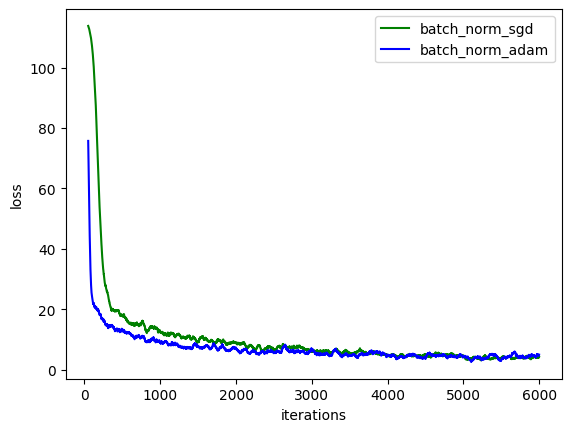

In [183]:
plt.plot(pd.DataFrame(batch_loss_history).rolling(50).sum()[50:], color='g', label='batch_norm_sgd')
plt.plot(pd.DataFrame(batch_adam_loss_history).rolling(50).sum()[50:], color='b', label='batch_norm_adam')

plt.yscale='symlog'
plt.xlabel("iterations")
plt.ylabel("loss")


plt.legend()


plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [ ]:
# Relu надежнее, бетчнорм ускоряет обучение, засчет стабилизации улучшает, Adam лучше сработал

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [177]:
net_ir = Sequential()
net_ir.add(Linear(784, 256))
net_ir.add(BatchNormalization())
net_ir.add(ChannelwiseScaling(256))
net_ir.add(ReLU())
net_ir.add(Dropout(0.3))
net_ir.add(Linear(256, 10))
net_ir.add(LogSoftMax())

In [179]:
optimizer_config = {'learning_rate':0.01, 'beta1':0.5, 'beta2':0.5, 'epsilon':0.01}
optimizer_state = {}
criterion = ClassNLLCriterion()
batch_adam_loss_history = []
batch_size = 56

for i in range(6):
    for x_batch, y_batch in get_batches((X_train.to_numpy(), y_train), batch_size):

        net_ir.zeroGradParameters()

        # Forward
        predictions = net_ir.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net_ir.backward(x_batch, dp)

        # Update weights
        adam_optimizer(net_ir.getParameters(),
                     net_ir.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        batch_adam_loss_history.append(loss)

Print here your accuracy on test set. It should be around 90%.

In [176]:
net_i.evaluate()
val = 0
for x_batch, y_batch in get_batches((X_test.to_numpy(), y_test), batch_size):
    predictions = net_i.forward(x_batch)
    predictions = np.argmax(predictions, 1)
    y_batch = np.argmax(y_batch, 1)
    val += (predictions==y_batch).sum()
print(val/len(X_test))







0.9659285714285715


In [181]:
net_ir.evaluate()
val = 0
for x_batch, y_batch in get_batches((X_test.to_numpy(), y_test), batch_size):
    predictions = net_ir.forward(x_batch)
    predictions = np.argmax(predictions, 1)
    y_batch = np.argmax(y_batch, 1)
    val += (predictions==y_batch).sum()
print(val/len(X_test))

0.9740714285714286


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [174]:
import torch
import torch.nn as nn
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.batch_norm = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 10)  #
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.log_softmax(x)
        return x